## BT5110 Group Project Data Cleaning

### Create individual JSON objects & Filtering

In [3]:
# Remove commas & square brackets from both json files
# Create json file for location data (type 1,2,3) and static data (type 5)

import json

# Read the content of the first JSON file
with open('ais-processed-log-2019-12.json', 'r') as file1:
    data1 = json.load(file1)

# Read the content of the second JSON file
# with open('ais-processed-log-2021-01.json', 'r') as file2:
#     data2 = json.load(file2)

print("Reading successful")

# Combine the JSON objects
combined_data = data1 #+ data2

# Separate the objects based on the "type" key
output_123 = [obj for obj in combined_data if obj['type'] in [1, 2, 3]]
output_5 = [obj for obj in combined_data if obj['type'] == 5]

print("Seperation successful")

# Write the filtered objects into separate JSON files
with open('ais-processed-data_location_201912.json', 'w') as out_file_123:
    for obj in output_123:
        json.dump(obj, out_file_123)
        out_file_123.write('\n')  # Separate objects by newlines

with open('ais-processed-data_static_201912.json', 'w') as out_file_5:
    for obj in output_5:
        json.dump(obj, out_file_5)
        out_file_5.write('\n')  # Separate objects by newlines

print("Writing successful")

Reading successful
Seperation successful
Writing successful


### Importing JSON files into PostgreSQL:

Use psql: 
``\copy shipstatic FROM 'C:\Users\Adison\Downloads\BT5110 AIS Data\ais-processed-data_location.json'``

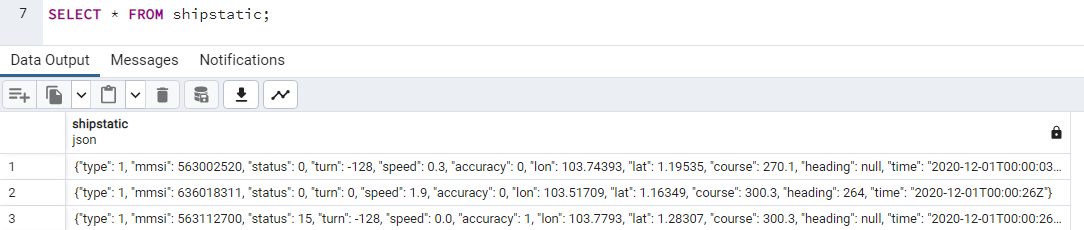

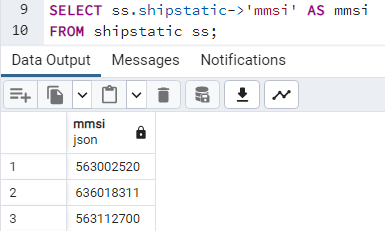

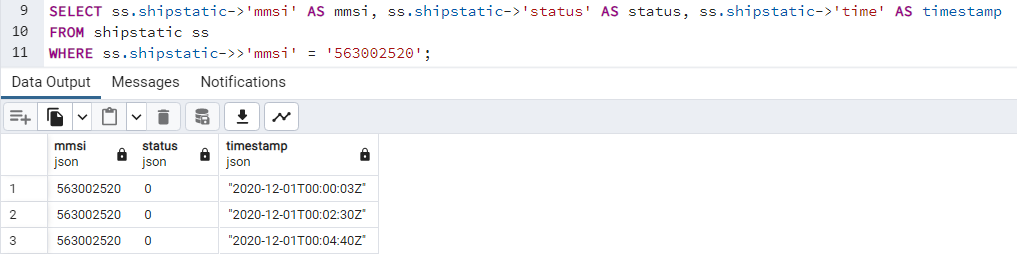

Thought: do we create the fact table such that there is a JSON object in each row, or try to create a "usual" SQL table with distinct columns?

### Data Cleaning for Static data:

Note: drop cols that will not be used first: ["destination", "type", "day", "month", "hour", "minute"]


Possible issues to clean: (1) unusual longitude and latitude numeric values inferring unreasonable locations (such as changes in latitude by more than 90, in longitude by more than 180, or incorrect datum inferring a vessel passing through land), (2) the final destination not being updated, (3) incorrect navigation direction (varying by more than 360), or (4) incorrect navigation speed. 

In [2]:
# Remove columns that will not be used from the static file

import json

# Open the original JSON file for reading
with open('ais-processed-data_static.json', 'r') as infile:
    data = infile.readlines()

# Define the keys to be removed
keys_to_remove = ["destination", "type", "day", "month", "hour", "minute"]

# Open a new JSON file for writing
with open('ais-processed-data_static_filtered.json', 'w') as outfile:
    # Iterate through the original data
    for json_str in data:
        # Parse the JSON string into a dictionary
        obj = json.loads(json_str)
        
        # Remove the specified keys
        for key in keys_to_remove:
            obj.pop(key, None)

        # Convert the modified dictionary back to a JSON string
        modified_json_str = json.dumps(obj)
        
        # Write the modified JSON object as a separate line in the new file
        outfile.write(modified_json_str + '\n')


Data cleaning:
- "mmsi" must have 9 digits and cannot be empty
- "imo" must have a maximum of 7 digits and cannot be empty
- "callsign" should have only numerical and text characters, there should be no special characters. If there are invalid characters, remove them but keep remaining characters.
- "shipname": only have text, numbers and space, there should be no other special characters. If there are invalid characters, remove them but keep remaining characters.
- "shiptype": if it has a value from 20 to 99, keep. Otherwise change the value to 0
- "to_bow", "to_stern", "to_port", "to_starboard" should all be numerical values
- "draught" is a numerical or float value

In [6]:
import json
import re

# Define a regular expression pattern for valid MMSI and IMO numbers
mmsi_pattern = re.compile(r'^\d{9}$')
imo_pattern = re.compile(r'^\d{1,7}$')

# Function to clean the "callsign" and "shipname" fields
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function to validate and clean the "shiptype" field
def clean_shiptype(shiptype):
    shiptype = int(shiptype)
    if 20 <= shiptype <= 99:
        return shiptype
    else:
        return 0

# Function to validate and clean the "draught" field
def clean_draught(draught):
    try:
        return float(draught)
    except ValueError:
        return None

# Read the input JSON file
with open("ais-processed-data_static_filtered.json", "r") as infile:
    data = infile.readlines()

cleaned_data = []
for line in data:
    obj = json.loads(line)
    
    # if these conditions are not met, will exclude that object 
    if (
        obj.get("mmsi") and mmsi_pattern.match(str(obj["mmsi"])) and
        obj.get("imo") and imo_pattern.match(str(obj["imo"])) and
        obj.get("callsign") and obj.get("shipname")
    ):
        obj["callsign"] = clean_text(obj["callsign"])
        obj["shipname"] = clean_text(obj["shipname"])
        obj["shiptype"] = clean_shiptype(obj["shiptype"])
        obj["to_bow"] = int(obj["to_bow"]) if obj.get("to_bow") else None
        obj["to_stern"] = int(obj["to_stern"]) if obj.get("to_stern") else None
        obj["to_port"] = int(obj["to_port"]) if obj.get("to_port") else None
        obj["to_starboard"] = int(obj["to_starboard"]) if obj.get("to_starboard") else None
        obj["draught"] = clean_draught(obj.get("draught"))
        
        if None not in obj.values():
            cleaned_data.append(obj)

# Write the cleaned data to a new JSON file
with open("ais-processed-data_static_cleaned_v1.json", "w") as outfile:
    for obj in cleaned_data:
        outfile.write(json.dumps(obj) + "\n")


#### Converting JSON to CSV file

In [2]:
# Convert JSON to CSV

import pandas as pd

# Specify the input JSON file and the output CSV file
json_file = "ais-processed-data_static_202001.json"
csv_file = "type5_cleaned.csv"

# Read the JSON file into a list of dictionaries
data = []
with open(json_file, "r") as file:
    for line in file:
        data.append(eval(line))

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

print(f"JSON file '{json_file}' has been converted to CSV file '{csv_file}'.")


JSON file 'ais-processed-data_static_cleaned_v1.json' has been converted to CSV file 'type5_cleaned.csv'.


## Archive

#### Extract MMSI, IMO & Name

In [6]:
# Extract mmsi imo and name
import json

# # Read the input JSON file
with open("ais-processed-data_static_cleaned_v1.json", "r") as infile:
    data = infile.readlines()

# Initialize arrays to store the extracted values
mmsi_values = []
imo_values = []
shipname_values = []

# Parse each line as a JSON object. Extract values from each JSON object and append them to the arrays
for line in data:
    obj = json.loads(line)
    mmsi_values.append(obj["mmsi"])
    imo_values.append(obj["imo"])
    shipname_values.append(obj["shipname"])

# Print or use the extracted arrays as needed
print(len(mmsi_values) , len(imo_values), len(shipname_values))

224409 224409 224409


#### Extract Unique IMO

In [2]:
# Extract all unique imo from location json

# import json

# # Read the input JSON file
# # with open("Archive/ais-processed-data_location.json", "r") as infile:
# with open("ais-processed-data_static_cleaned_v1.json", "r") as infile:
#     data = infile.readlines()

# # Create an array to store the extracted "mmsi" values
# imo_values_loc = []

# # Parse each line as a JSON object and extract the "mmsi" values
# for line in data:
#     obj = json.loads(line)
#     if "imo" in obj:
#         imo_values_loc.append(obj["imo"])

# # Print or use the mmsi_values array as needed
# print(len(imo_values_loc))

224409


In [ ]:
# Extract all unique imo from static json

# import json

# Read the input JSON file
# with open("Archive/ais-processed-data_static.json", "r") as infile:
#     data = infile.readlines()

# # Create an array to store the extracted "mmsi" values
# mmsi_values_stat = []

# # Parse each line as a JSON object and extract the "mmsi" values
# for line in data:
#     obj = json.loads(line)
#     if "mmsi" in obj:
#         mmsi_values_stat.append(obj["imo"])

# # Print or use the mmsi_values array as needed
# print(len(mmsi_values_stat))

In [ ]:
# mmsi_values_combined = mmsi_values_stat + mmsi_values_loc
# print(len(mmsi_values_combined))

In [3]:
# Convert to set to remove duplicates
# mmsi_values_combined_unique = list(set(mmsi_values_combined))
# print(len(mmsi_values_combined_unique))

# imo_values_combined_unique = list(set(imo_values_loc))
# print(len(imo_values_combined_unique))

5293


In [4]:
# import csv

# # Define the CSV file name
# csv_file = "mmsi_imo_name_ships.csv"

# # Open the CSV file in write mode and write the list to it
# with open(csv_file, "w", newline="") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(["IMO Values"])  # Optional header row
#     for value in imo_values_combined_unique:
#         writer.writerow([value])



#### Update CSV file

In [ ]:
import json
import csv

# Open the JSON file and read the data
with open("ais-processed-data_static_cleaned_v1.json", "r") as json_file:
    data = json_file.read()
    json_data = data.strip().split('\n')

# Define the CSV file name
csv_file = "mmsi_imo_name_ships_v2.csv"

# Create and open the CSV file for writing
with open(csv_file, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write the header row
    csv_writer.writerow(["mmsi", "imo", "shipname"])
    
    # Parse each JSON object and extract the desired fields
    for json_str in json_data:
        json_obj = json.loads(json_str)
        mmsi = json_obj.get("mmsi", "")
        imo = json_obj.get("imo", "")
        shipname = json_obj.get("shipname", "")
        
        # Write the extracted values to the CSV file
        csv_writer.writerow([mmsi, imo, shipname])

print(f"Data has been written to {csv_file}")


Data has been written to <_io.TextIOWrapper name='mmsi_imo_name_ships_v2.csv' mode='w' encoding='cp1252'>


#### Extract a subset of keys from JSON file, and output as CSV

In [4]:
import json
import csv

# Define the input and output file names
input_file = "ais-processed-data_static_201912.json"
output_file = "ais-processed-data_static_201912_filtered.csv"

# Define the keys you want to extract
keys_to_extract = ["mmsi", "imo", "callsign", "shipname", "shiptype", "to_bow", "to_stern", "to_port", "to_starboard"]

# Initialize a list to store the extracted data
extracted_data = []

# Open and read the JSON file
with open(input_file, 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        # Create a dictionary containing only the desired keys and values
        extracted_data.append({key: data[key] for key in keys_to_extract})

# Write the extracted data to a CSV file
with open(output_file, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=keys_to_extract)
    writer.writeheader()
    writer.writerows(extracted_data)

print(f"Data extracted and saved to {output_file}")


Data extracted and saved to ais-processed-data_static_201912_filtered.csv


#### Extract JSON objects based on a defined list of 'mmsi' values

In [18]:
import pandas as pd

# Import list of mmsi values

# Read the CSV file into a DataFrame
data = pd.read_csv("unique_mmsi_imo_values.csv")
# data = pd.read_excel("unique_mmsi_imo_values.xlsx")

# Display the DataFrame
data.head()

,shipId,imo,mmsi,vessel_name
0,1,9726671,105792957,MAERSK STADELHORN
1,2,9235268,205408000,SA EUROPE
2,3,9230050,205421000,EXCALIBUR
3,4,9444649,205553000,EXEMPLAR
4,5,9416733,205559000,FRATERNITY


In [19]:
df_imo = data['mmsi']
print(len(df_imo))
df_imo.head()

6791


0    105792957
1    205408000
2    205421000
3    205553000
4    205559000
Name: mmsi, dtype: int64

In [20]:
list_imo = list(df_imo)
len(list_imo)

6791

In [21]:
import json

# List of mmsi values to filter
mmsi_list = list_imo

# Read the input JSON file
with open('ais-processed-data_location_202001.json', 'r') as input_file:
    data = input_file.readlines()

print("File Open")
    
# Initialize an empty list to store the filtered JSON objects
filtered_objects = []

# Iterate through each line in the file
for line in data:
    obj = json.loads(line)
    if obj.get('mmsi') in mmsi_list:
        filtered_objects.append(obj)

print("Check complete")
        
# Write the filtered JSON objects to a new JSON file
with open('ais-processed-data_location_202001_filtered_comma.json', 'w') as output_file:
    for obj in filtered_objects:
        output_file.write(json.dumps(obj) + ',\n')

print("Filtered data exported to json file")


File Open
Check complete
Filtered data exported to json file


In [1]:
# For counting of 1,2,3

import json
    
# Load the JSON data
with open('base json download/ais-processed-log-2020-01.json') as f:
    data = json.load(f)

print("File Open")
    
# Initialize counters
count_1 = 0
count_2 = 0
count_3 = 0
count_other = 0

# Iterate over the JSON objects
for obj in data:
    if obj['type'] == 1:
        count_1 += 1
    elif obj['type'] == 2:
        count_2 += 1
    elif obj['type'] == 3:
        count_3 += 1
    else:
        count_other += 1

# Print the counts
print(f'JSON objects with type 1: {count_1}')
print(f'JSON objects with type 2: {count_2}')
print(f'JSON objects with type 3: {count_3}')
print(f'JSON objects of other types: {count_other}')


File Open
JSON objects with type 1: 9636392
JSON objects with type 2: 781
JSON objects with type 3: 1943030
JSON objects of other types: 1419599


In [5]:
count_1 + count_2 + count_3 #+ count_other

11580203